In [ ]:
from pathlib import Path
import os
import copy

import xarray as xr
import numpy as np
import pandas as pd

from eofs.xarray import Eof

from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import seaborn as sns

from deepS2S.utils.utils_plot import plot_examples
from deepS2S.preprocessing.regimes import get_general_probabilistic_regimes, get_dominant_regime

#set random seed for reproducibility.
import random

random.seed(42)

In [ ]:
data_name = 'ERA5'
test = False #Set to true if you want to test the compatibility with the hindcast
cfd = Path(os.getcwd()).parent.absolute()
par_cdf = Path(cfd).parent.absolute()
ddir = str(par_cdf) + f'/Data/'
results_directory = f'{ddir}{data_name}/Preprocessing'
if not os.path.exists(results_directory):
        os.makedirs(results_directory)

In [ ]:
# Load ERA5 Data.
start_yr = 1980
year_end = 2023
smoothing = 7
input_path = Path(f'{ddir}/{data_name}/datasets/z_500_1.40625deg_{start_yr}-{year_end}_northern_hemi_2d.nc')
z500_anomalies = xr.open_dataarray(input_path)

z500_anomalies = - z500_anomalies.sel(lon=slice(-90, 30), lat=slice(80,20)).squeeze()



(5901, 43, 86)


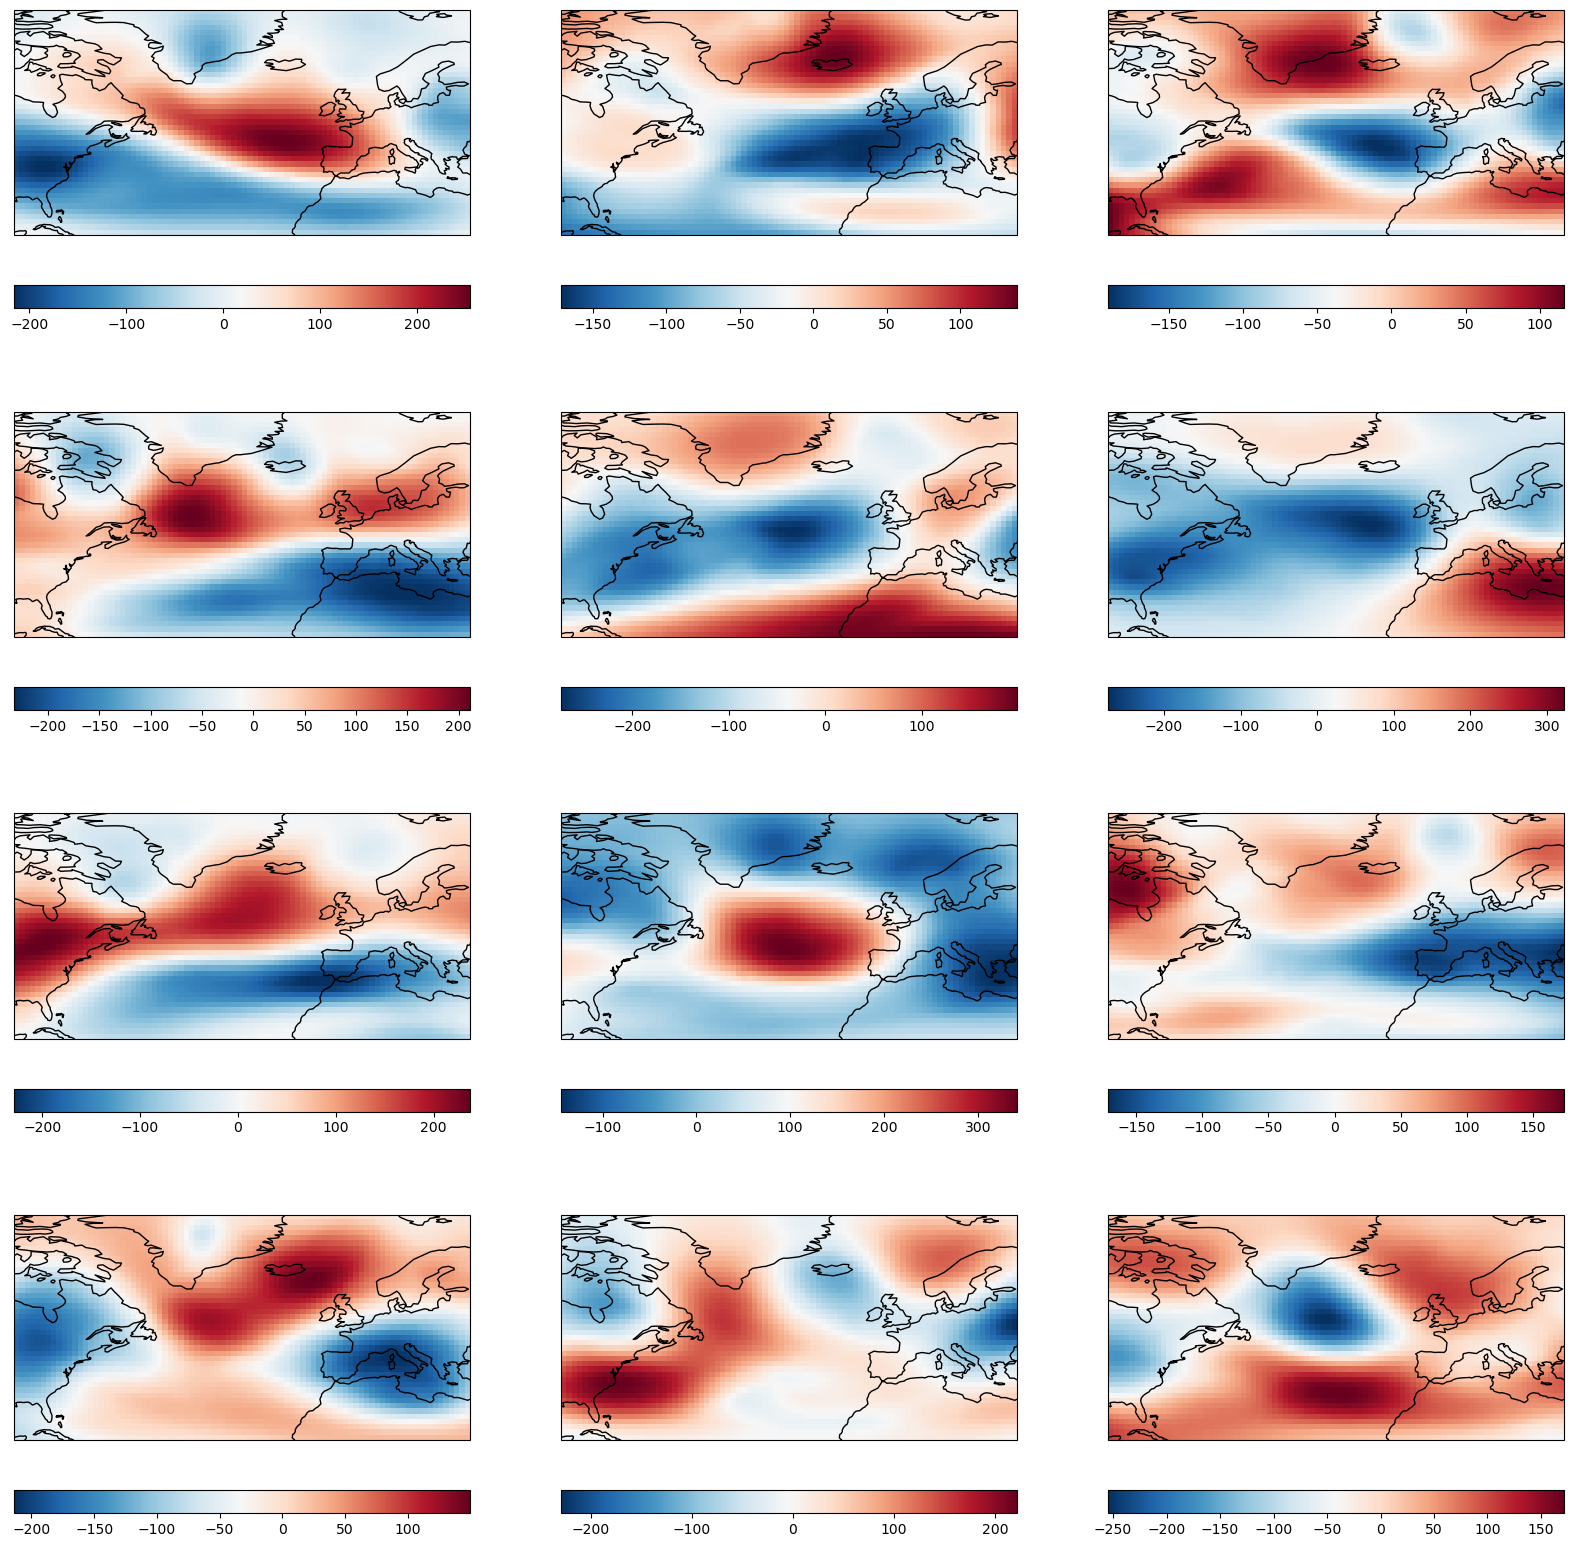

In [6]:
examples = np.random.choice(np.arange(len(z500_anomalies.time)), 12)
plot_examples(z500_anomalies, examples=examples)

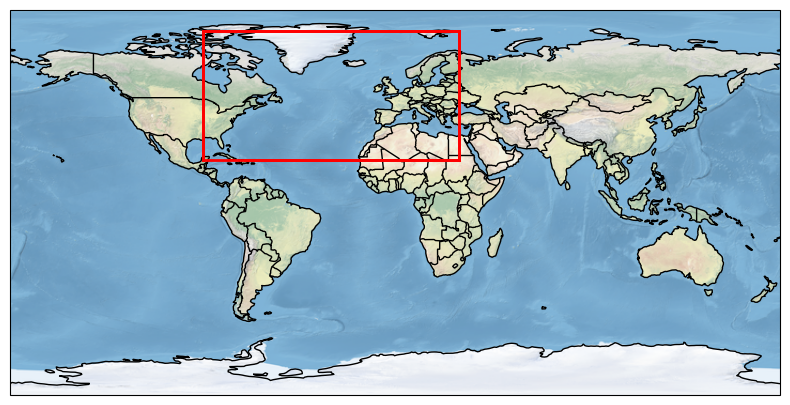

In [7]:
# Create a new figure
fig = plt.figure(figsize=(10, 5))

# Set up the map projection
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

# Add coastlines and borders
ax.coastlines()
ax.add_feature(ccrs.cartopy.feature.BORDERS)

# Set the extent of the map to cover the whole world
ax.set_global()
ax.stock_img()

# Draw the red box
ax.plot([-90, 30], [20, 20], transform=ccrs.PlateCarree(), color='red', linewidth=2)
ax.plot([-90, 30], [80, 80], transform=ccrs.PlateCarree(), color='red', linewidth=2)
ax.plot([-90, -90], [20, 80], transform=ccrs.PlateCarree(), color='red', linewidth=2)
ax.plot([30, 30], [20, 80], transform=ccrs.PlateCarree(), color='red', linewidth=2)

# Draw the red box
ax.plot([-70, 30], [20, 20], transform=ccrs.PlateCarree(), color='red', linewidth=2)
ax.plot([-90, 30], [80, 80], transform=ccrs.PlateCarree(), color='red', linewidth=2)
ax.plot([-90, -90], [20, 80], transform=ccrs.PlateCarree(), color='red', linewidth=2)
ax.plot([30, 30], [20, 80], transform=ccrs.PlateCarree(), color='red', linewidth=2)

# fig.savefig('NAE_map_section.pdf', bbox_inches='tight')

## Calculate regimes

In [ ]:
# perform EOF analysis
num_m = 14

z500_anomalies = z500_anomalies.dropna('time')
weights = np.cos(np.deg2rad(z500_anomalies.lat))
z500_anomalies_weighted = z500_anomalies*weights

In [ ]:
eof_solver = Eof(z500_anomalies_weighted.rename({'lon':'longitude', 'lat':'latitude'}), center=True)
pcs_z500 = eof_solver.pcs(npcs=num_m)
eofs_z500 = eof_solver.eofs()
KMeans_z500 = KMeans(n_clusters=4, n_init=50, random_state=0)
kmeans = KMeans_z500.fit(pcs_z500)

In [46]:
# total variance explained by first 14 EOFs
classes = list(kmeans.labels_)
for i in range(4):
    print(f'Number of observations in cluster {i}: {classes.count(i)/len(classes)*100}%')

Number of observations in cluster 0: 31.90984578884935%
Number of observations in cluster 1: 19.234028130825283%
Number of observations in cluster 2: 24.504321301474327%
Number of observations in cluster 3: 24.35180477885104%


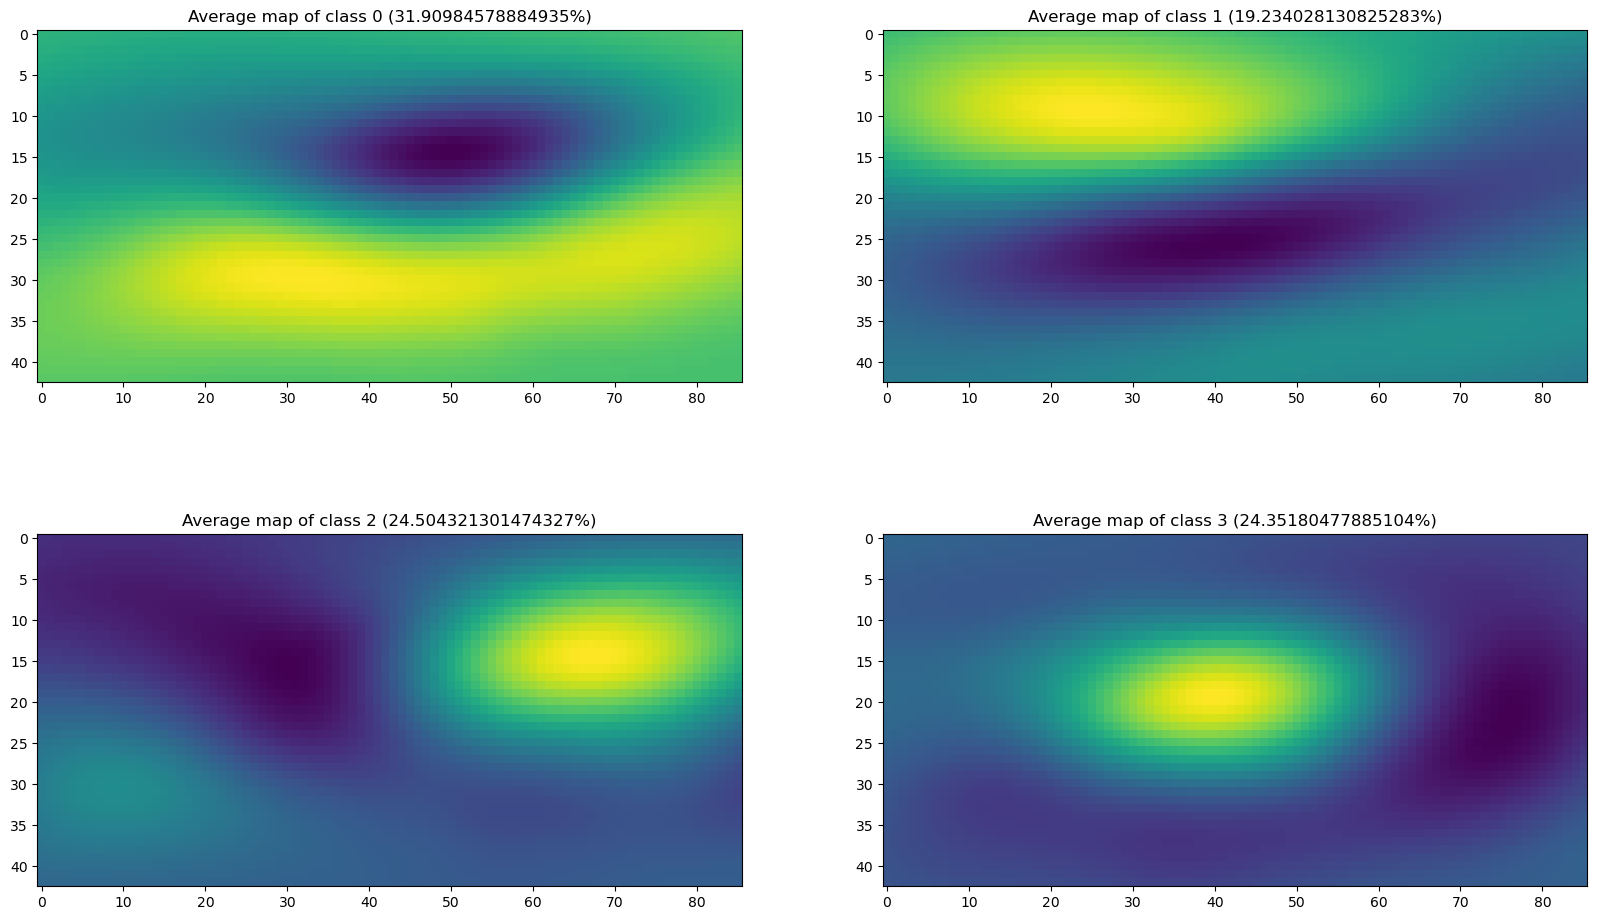

In [36]:
fig, axes = plt.subplots(2,2, figsize=(20,12))
mean_maps = {}
for c, ax in enumerate(axes.flatten()):
    samples_c = [i for i, x in enumerate(classes) if x == c]
    mean_maps[c] = z500_anomalies.isel(time=samples_c).mean('time')
    ax.imshow(mean_maps[c])
    ax.set_title(f'Average map of class {c} ({classes.count(c)/len(classes)*100}%)')

In [37]:
# m = projected[:2]
m = pcs_z500[:,:2].T

In [38]:
m.shape

(2, 5901)

Text(0, 0.5, 'EOF2')

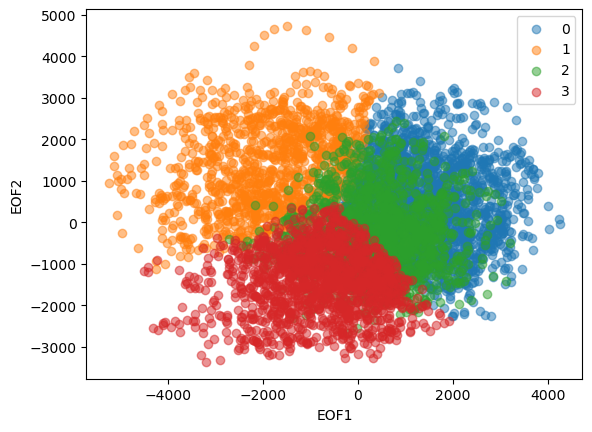

In [39]:
fig, ax = plt.subplots(1,1)
for c in range(4):
    samples_c = [i for i, x in enumerate(classes) if x == c]
    # ax.scatter(*m[:,samples_c], labels=f'Class {c}', alpha=0.5)
    ax.scatter(*m[:,samples_c], alpha=0.5)


ax.legend(['0', '1', '2', '3'])
ax.set_xlabel('EOF1')
ax.set_ylabel('EOF2')

In [ ]:
# Plot the leading EOF expressed as covariance in the European/Atlantic domain.
dt_tp = 'ERA5'
cl_order = [3,1,0,2]
reg ={
0: 'Scandinavian blocking',
1: 'NAO -',
2: 'Atlantic Ridge',  
3: 'NAO+',
}

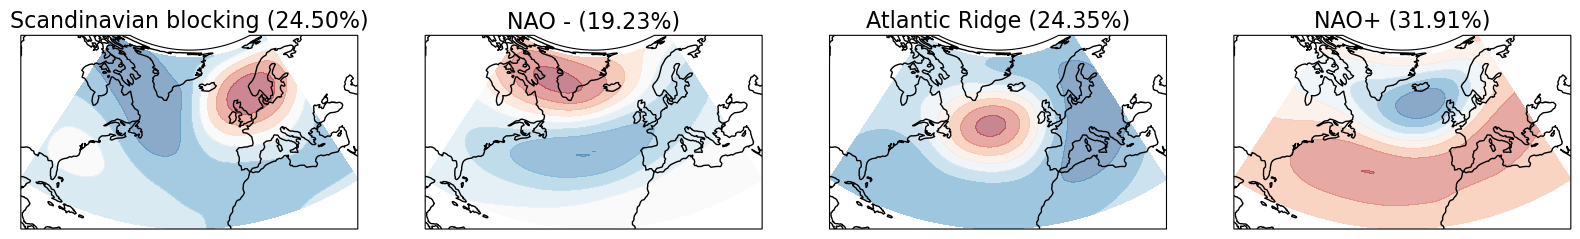

In [ ]:
## horizontal figure
proj = ccrs.AlbersEqualArea(central_longitude=-30, central_latitude=50)
fig, axes = plt.subplots(1,4,figsize=(20,8), subplot_kw=dict(projection=proj))
axes = axes
for c in range(len(mean_maps)):
    ax = axes[cl_order[c]]
    data = mean_maps[c]
    ax.contourf(data.lon.values, data.lat.values, data.squeeze().values,
                cmap=plt.cm.RdBu_r, transform=ccrs.PlateCarree(), alpha=0.5)
    name_reg = reg[cl_order[c]]
    ax.coastlines()
    ax.set_title(f'{name_reg} ({classes.count(c)/len(classes)*100:.2f}%)', fontsize=16)
plt.show()
if year_end:
    fig.savefig(f"{results_directory}/horizontal_map_NAE_regimes_smoothing{smoothing}_{start_yr}_{year_end}_{dt_tp}_{num_m}EOF.png", dpi=600, bbox_inches='tight')
else:
    fig.savefig(f"{results_directory}/horizontal_map_NAE_regimes_smoothing{smoothing}_{start_yr}_{dt_tp}_{num_m}EOF.png", dpi=600, bbox_inches='tight')

In [ ]:
# map clusters to regime, based on the average map
#     ['SB(0)', 'NAO-(1)', "NAO+(2)", 'AR(3)']
regime_map = {
    0: 3,  
    1: 1,  
    2: 0,  
    3: 2   
}

classes = np.array([regime_map[c] for c in classes])

In [ ]:
# save the NAE regimes of the data points used to generate the clusters
nae_regimes_pat = input_path.parent / Path(f'{input_path.stem}_NAEregimes{input_path.suffix}')
nae_ds = xr.DataArray(
    data=np.array(classes),
    dims=['time'],
    coords=dict(
        time=z500_anomalies.time.values,
        season=('time', z500_anomalies.season.values)
    ),

    attrs=dict(
        description=("Time series of North atlantic weather regimes. "
                     "For each date in the time dimension one of four classes "
                     "was determined (SB(0), NAO-(1), AR(2), NAO+(3))."
                     "The basis for calculation were the Z500 anomalies over the North Atlantic "
                     "averaged over 7 consecutive days starting on the date specified as "
                     "time coordinate."
                    )
    )
)
print(nae_regimes_pat)

/mnt/beegfs/home/bommer1/Project3/WiOSTNN/Version1/data/ERA5/z_500_1.40625deg_1980-2023_northern_hemi_2d_NAEregimes.nc


## Cluster centroid distances


In [75]:
centroid_distances_z500 = KMeans_z500.transform(pcs_z500)
inverse_centroid_distances_z500 = 1/centroid_distances_z500[:, cl_order]
probabilistic_regimes = inverse_centroid_distances_z500/inverse_centroid_distances_z500.sum(axis=1)[:, np.newaxis]

In [ ]:
print(np.sum(np.argmax(probabilistic_regimes, axis=1) == classes) == len(classes))

5901


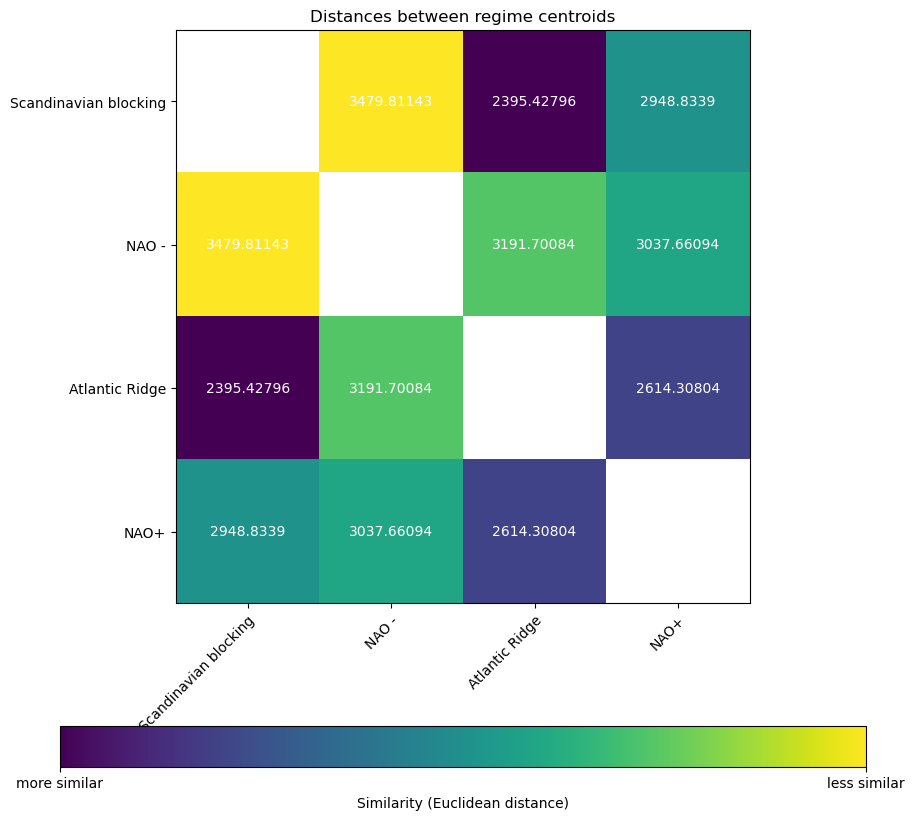

In [79]:
distance = lambda x, y: np.sqrt(np.sum(np.square(x-y)))
# enter regime names in the order they are plotted above
regimes = ['Scandinavian blocking', 'NAO -', 'Atlantic Ridge', 'NAO+']
n_clusters = len(regimes)
distances = np.zeros((n_clusters, n_clusters))
for ix in range(n_clusters):
    for jx in range(n_clusters):
        i = cl_order[ix]
        j = cl_order[jx]
        if i == j: distances[i, j] = None
        else:
            distances[i,j] = round(distance(kmeans.cluster_centers_[i], kmeans.cluster_centers_[j]), 5)

fig, ax = plt.subplots(figsize=(10,10))
im = ax.imshow(distances)

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(n_clusters), labels=regimes)
ax.set_yticks(np.arange(n_clusters), labels=regimes)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(n_clusters):
    for j in range(n_clusters):
        text = ax.text(j, i, distances[i, j],
                       ha="center", va="center", color="w")

ax.set_title("Distances between regime centroids")
fig.tight_layout()
cbar = fig.colorbar(im, label='Similarity (Euclidean distance)',
                    ticks=[np.min([d for d in distances.flatten() if ~np.isnan(d)]),
                           np.max([d for d in distances.flatten() if ~np.isnan(d)])],
                    orientation='horizontal')
cbar.ax.set_xticklabels(['more similar', 'less similar'])
plt.show()
fig.savefig(f"{results_directory}/cluster_seperation_{dt_tp}.png", dpi=600, bbox_inches='tight')

In [81]:
centers_kmeans = kmeans.cluster_centers_#[cl_order]
vec_dist_z500 = np.zeros((len(pcs_z500), 4))
for c in range(4):
    class_pcs = pcs_z500
    center_c = kmeans.cluster_centers_[c]
    for cs in range(len(pcs_z500)):
        vec_dist_z500[cs,c] = np.sqrt(np.sum(np.square(class_pcs[cs,:] - center_c)))/np.sqrt(np.sum(np.square(class_pcs[cs,:])))

inverse_vec_dist_z500 = 1/vec_dist_z500[:,cl_order]
probabilistic_regimes_z500_vec = inverse_vec_dist_z500/inverse_vec_dist_z500.sum(axis=1)[:, np.newaxis]


In [ ]:

nae_prob_pat = input_path.parent / Path(f'{input_path.stem}_probabilistic_NAEregimes{input_path.suffix}')
nae_prob_ds = xr.DataArray(
    data=np.array(probabilistic_regimes_z500_vec),
    dims=['time', 'regime'],
    coords=dict(
        regime=('regime', regimes),
        time=z500_anomalies.time.values,
        season=('time', z500_anomalies.season.values)
    ),

    attrs=dict(
        description=("Time series of North atlantic weather regimes. "
                     "For each date in the time dimension one of four classes "
                     "was determined (SB(0), NAO-(1), AR(2), NAO+(3))."
                     "The basis for calculation were the Z500 anomalies over the North Atlantic "
                     "averaged over 7 consecutive days starting on the date specified as "
                     "time coordinate."
                    )
    )
)
nae_prob_ds.to_netcdf(nae_prob_pat)

## Compare to Hindcast regimes

In [88]:
import pandas as pd
fiona_regs = pd.read_csv('/mnt/beegfs/home/bommer1/WiOSTNN/Version1/data/regime_labels_fiona_0909.csv').to_xarray()
fiona_regs = fiona_regs.rename({'index': 'time'})
fiona_regs = fiona_regs.assign_coords({'time': pd.to_datetime(fiona_regs['Date'].values)})
fiona_regs = fiona_regs.sel(time=nae_ds['time']).target_label

regime_map = {
    0: 2,  
    1: 1,  
    2: 3,  
    3: 0   
}


fiona_classes = np.array([regime_map[c] for c in fiona_regs.values]) 

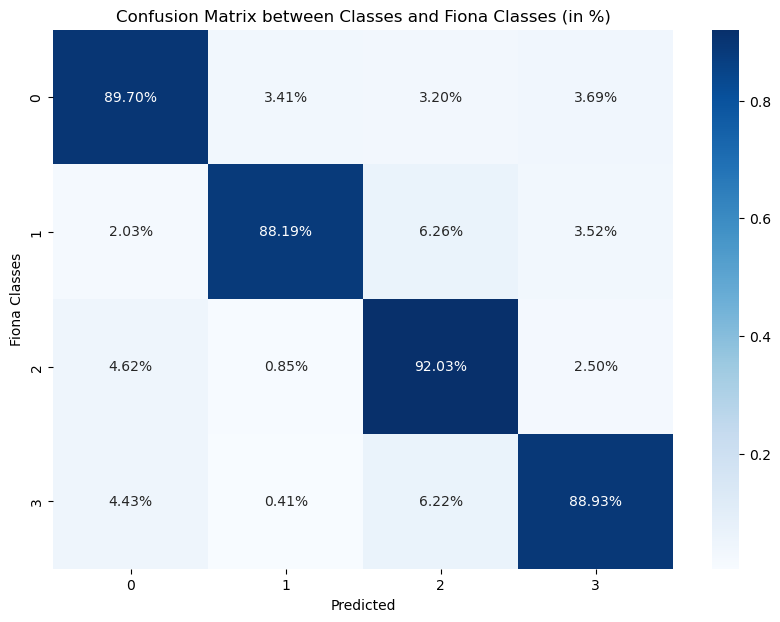

In [89]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the confusion matrix
conf_matrix = confusion_matrix(classes, fiona_classes)

# Normalize the confusion matrix by row (i.e., by the number of actual instances)
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]


# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2%', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Fiona Classes')
plt.title('Confusion Matrix between Classes and Fiona Classes (in %)')
plt.show()